# Shape Statistical Analysis

This tutorial guides through the shape statistical analysis from [deformetrica](http://www.deformetrica.org) outputs

The tutorial uses the data included in the subdirectory **data**.

## Python Packages required:

- matplotlib

- numpy

- vtk

- pandas


## Recommended Optional software

- [meshlab](http://www.meshlab.net): Useful to manipulate a mesh object (esp. for mesh decimation)

- [paraview](https://www.paraview.org/): Useful to simply visualise mesh objects and roughly align them together



## Imports

In [1]:
%matplotlib inline

### General Imports
import matplotlib.pyplot as plt
from glob import glob as glob
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm

### VTK imports
import vtk
from vtk import vtkPolyDataReader
from vtk import vtkPolyDataWriter
from vtk import vtkUnstructuredGridReader
from vtk import vtkUnstructuredGridWriter
from vtk import vtkPolyData
from vtk import vtkPoints
from vtk import vtkCellArray
from vtk import vtkProcrustesAlignmentFilter as Procrustes
from vtk import vtkMultiBlockDataGroupFilter as GroupFilter
from vtk import vtkLandmarkTransform
from vtk import vtkTransformPolyDataFilter as TransformFilter
from vtk.util import vtkConstants
from vtk import vtkIdList
from vtk import vtkIdTypeArray
from vtk import vtkTriangle
from vtk import vtkFloatArray
from vtk import vtkTetra
from vtk import vtkMath


## Deformetrica

This tutorial requires the installation of [deformetrica](http://www.deformetrica.org)



In [2]:
def which(program):
    ''' Search for a program on disk
    '''
    import os
    def is_exe(fpath):
        return os.path.isfile(fpath) and os.access(fpath, os.X_OK)

    fpath, fname = os.path.split(program)
    if fpath:
        if is_exe(program):
            return program
    else:
        for path in os.environ["PATH"].split(os.pathsep):
            exe_file = os.path.join(path, program)
            if is_exe(exe_file):
                return exe_file

    return None

deformetrica_location = which('deformetrica')
if deformetrica_location is None:
    print('deformetrica error: Please install the deformetrica library: www.deformetrica.org')
else: 
    print('Found deformetrica at this location: {}'.format(deformetrica_location))

Found deformetrica at this location: /Users/redheay/software/deformetrica/deformetrica-3.0/build/deformetrica


## Load Data

The output data of [deformetrica](http://www.deformetrica.org) consists on 3 important files:

- `Atlas_ControlPoints.txt`: The final control points of the population atlas, representating positions of large variability
- `Atlas_Momenta.txt`: The momenta of the each subject of the population (describing momentum from the population's mean)
- `Atlas_initial_template.vtk`: The final mean shape of the population

----

**Note**: For the sake of this example, these files are present in `data/shapestatistics` directory. You should replace them by yours, or modify the notebook accordingly.

In [3]:
working_directory = os.path.join(os.getcwd(), 'data', 'shapestatistics')

controlpoints = np.loadtxt(os.path.join(working_directory, 'Atlas_ControlPoints.txt'))
f = open(os.path.join(working_directory, 'Atlas_Momentas.txt'))
first_line = f.readline().split(' ')
number_of_subjects = int(first_line[0])
number_of_controlpoints = int(first_line[1])
dimension = int(first_line[2])
f.close()
momenta = np.loadtxt(os.path.join(working_directory, os.path.join(working_directory, 'Atlas_Momentas.txt')), 
                     skiprows=2)
momenta_linearised = momenta.reshape([number_of_subjects, dimension*number_of_controlpoints])

print('Control Points: {}'.format(number_of_controlpoints))
print('Subjects: {}'.format(number_of_subjects))
print('Dimension: {}'.format(dimension))

Control Points: 200
Subjects: 16
Dimension: 3


## Define population's groups

In order to define classification power of the statistical analysis, the definition of sub groups is required.

This can be materialised by a file describing which subject belongs to which group.

In this toy example, we have only **2 subjects**. We can therefore define our classes using the following code

In [4]:
df = pd.DataFrame()
df['initial mesh file'] = ['07_5f_Rmand.vtk', '08_6a_Rmand.vtk','08_6b_Rmand.vtk','08_6g_Rmand.vtk','09_4e_Rmand.vtk','09_4i_Rmand.vtk','09_4j_Rmand.vtk','09_4k_Rmand.vtk','09_4l_Rmand.vtk','11_4e_Rmand.vtk','11_4f_Rmand.vtk','11_4g_Rmand.vtk','13_5a_Rmand.vtk','13_5b_Rmand.vtk','13_5c_Rmand.vtk','13_5d_Rmand.vtk']
df['GroupId'] = [1,-1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1,1,-1]
df

,initial mesh file,GroupId
0,07_5f_Rmand.vtk,1
1,08_6a_Rmand.vtk,-1
2,08_6b_Rmand.vtk,-1
3,08_6g_Rmand.vtk,1
4,09_4e_Rmand.vtk,1
5,09_4i_Rmand.vtk,-1
6,09_4j_Rmand.vtk,-1
7,09_4k_Rmand.vtk,1
8,09_4l_Rmand.vtk,1
9,11_4e_Rmand.vtk,-1


## Generalisation

For a real case scenario, please create your own dataframe containing the column 'GroupId', separating groups between '-1' and '1'.

You can load it from a `.csv` or `.txt` file for convenience:

In [26]:
if os.path.exists(os.path.join(working_directory, 'classes.txt')):
    df = pd.DataFrame()
    df['initial mesh file'] = [
        '07_5f.vtk',
        '08_6a.vtk',
        '08_6b.vtk',
        '08_6g.vtk',
        '09_4e.vtk',
        '09_4i.vtk',
        '09_4j.vtk',
        '09_4k.vtk',
        '09_4l.vtk',
        '11_4e.vtk',
        '11_4f.vtk',
        '11_4g.vtk',
        '13_5b.vtk',
        '13_5c.vtk',
        '13_5d.vtk',
        '13_5a.vtk']

    classes = np.loadtxt(os.path.join(working_directory, 'classes.txt'))
    df['GroupId'] = classes

    df

## Subgroups definition

`g1` and `g2` identify the IDs of the list belonging to each subgroup

In [5]:
g1 = df['GroupId'].values < 0
g2 = df['GroupId'].values > 0

## Kernel Principal Component Analysis (kPCA)

Using scikit.learn, we can derive the Kernel PCA decomposition of our atlas momenta.

Kernel PCA was introduced in:

```
Schölkopf, Bernhard, Alexander Smola, and Klaus-Robert Müller. "Kernel principal component analysis." International Conference on Artificial Neural Networks. Springer, Berlin, Heidelberg, 1997.
```

[Springer link](https://link.springer.com/chapter/10.1007%2FBFb0020217)


It allows to describe data in a reduced dimensional space. 

Our data (the momenta from the atlas) consists on N subjects (N points), each point is of dimension 3.M, with M being the number of control points. In consequence, our dimensionality is 3.M. In order to evaluate the principal variatons of this data, we use kPCA to reduce this dimension to n. Arbitrarily, we choose n=5. These dimensions represent a decreasing order of variation of the input dataset.

In this reduced dimensional space, also called `feature space`, a subject corresponds to a point in n dimension. We can for instance plot that point in the first 2 dimensions. It is a simple way to visually inspect the first modes of variation of a dataset. 

-----

**Note**: One parameter of the kPCA approach is the `gamma` for the radial basis function. We chose `gamma=.25`





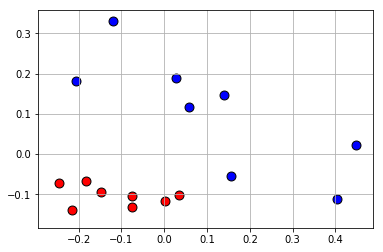

In [26]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(momenta_linearised)
plt.scatter(X_kpca[g1, 0], X_kpca[g1, 1], c="red",
            s=80, edgecolor='k')
plt.scatter(X_kpca[g2, 0], X_kpca[g2, 1], c="blue",
            s=80, edgecolor='k')
plt.grid(True)

<IPython.core.display.Javascript object>


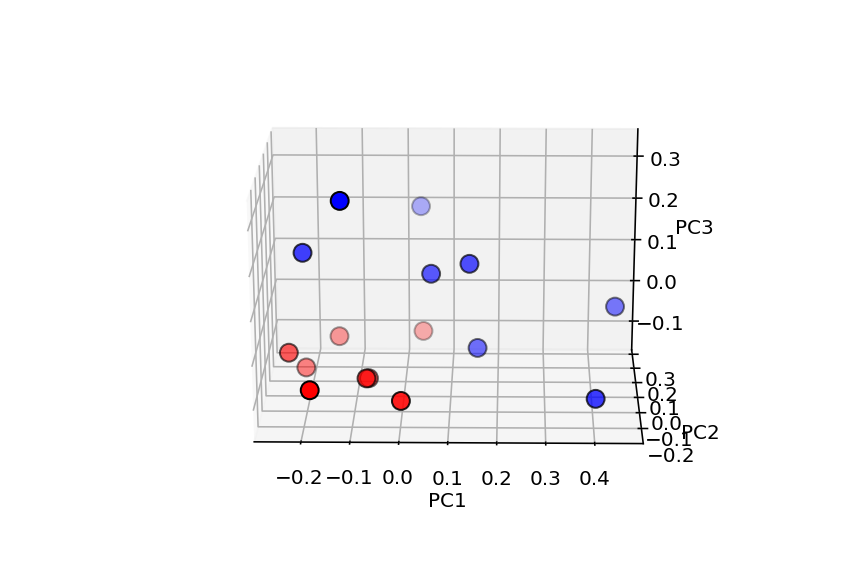

Text(0.5,0,'PC3')

In [53]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=5, gamma=.25)
X_kpca = kpca.fit_transform(momenta_linearised)

ax.scatter(X_kpca[g1, 0], X_kpca[g1, 1], X_kpca[g1, 2], c="red",
            s=80, edgecolor='k')
ax.scatter(X_kpca[g2, 0], X_kpca[g2, 1], X_kpca[g2, 2], c="blue",
            s=80, edgecolor='k')
plt.grid(True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

## Eigenvalues / Eigenvectors extraction

The eigenvalues are stored in `kpca.lambdas_` and the vectors in `kpca.alphas_`. The vectors should already be normalised, but we normalise them anyway

In [10]:
eigenvalues = kpca.lambdas_
eigenvectors = kpca.alphas_ / np.linalg.norm(kpca.alphas_, axis=0)

eig = pd.DataFrame()
eig['PCA dimension'] = ['PC{}'.format(idx+1) for idx in range(len(eigenvalues))]
eig['cum. variability (in %)'] = 100 * np.cumsum(eigenvalues) / np.sum(eigenvalues)
pd.set_option('precision', 2)
eig['lambda'] = eigenvalues
eig['alpha'] = list(np.transpose(eigenvectors))

eig

,PCA dimension,cum. variability (in %),lambda,alpha
0,PC1,37.08,0.64,"[0.5031415112473837, -0.09376162552708356, -0...."
1,PC2,57.98,0.36,"[-0.2927054639871406, 0.014692252862704536, 0...."
2,PC3,76.24,0.32,"[-0.1985632352582975, -0.23389812758186704, -0..."
3,PC4,89.99,0.24,"[0.41393801149738996, 0.29335544369897504, 0.1..."
4,PC5,100.00,0.17,"[-0.3995146585427934, -0.050424781806981234, -..."


## Write PCA points on disk

the PCA points can be saved on disk for future use

We use pandas for that and save it as **kpca.csv**

In [31]:
for idx in range(X_kpca.shape[1]):
    df['PC{}'.format(idx+1)] = X_kpca[:, idx]
df.to_csv(os.path.join(working_directory, 'kpca.csv'))
df

,initial mesh file,GroupId,PC1,PC2,PC3,PC4,PC5
0,07_5f_Rmand.vtk,1,4.04e-01,-1.76e-01,-0.11,2.02e-01,-1.67e-01
1,08_6a_Rmand.vtk,-1,-7.52e-02,8.85e-03,-0.13,1.43e-01,-2.10e-02
2,08_6b_Rmand.vtk,-1,-2.15e-01,9.82e-02,-0.14,7.00e-02,-8.27e-03
3,08_6g_Rmand.vtk,1,5.86e-02,2.77e-03,0.12,4.34e-02,2.75e-01
4,09_4e_Rmand.vtk,1,-1.20e-01,-1.62e-01,0.33,-1.02e-01,-1.23e-01
5,09_4i_Rmand.vtk,-1,6.45e-04,-1.86e-01,-0.12,-2.23e-01,-4.51e-02
6,09_4j_Rmand.vtk,-1,-7.61e-02,-7.05e-02,-0.10,-2.34e-01,-3.19e-02
7,09_4k_Rmand.vtk,1,4.48e-01,6.09e-02,0.02,-3.97e-02,7.00e-02
8,09_4l_Rmand.vtk,1,1.57e-01,-3.19e-03,-0.05,-9.78e-03,9.33e-02
9,11_4e_Rmand.vtk,-1,3.39e-02,2.54e-01,-0.10,-1.45e-01,5.02e-02


## Vector Separating the two sub populations

This vector best describes the separation between group 1 and group 2.

It is described in the `feature space`. This means we can project back this vector in the `momenta` space, in order to derive the actual displacement between the group 1 `mean` and group 2 `mean`. 

In [32]:
mean_g1 = np.array([np.mean(X_kpca[g1, idx]) for idx in range(X_kpca.shape[1])])
mean_g2 = np.array([np.mean(X_kpca[g2, idx]) for idx in range(X_kpca.shape[1])])

# separation goes from group1 (normal) to group2 (patients)
separation_vector = mean_g2 - mean_g1

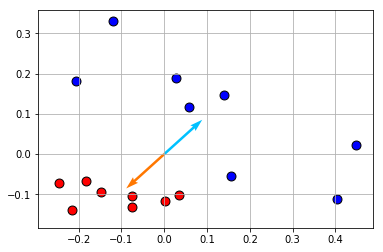

In [36]:
%matplotlib inline
plt.scatter(X_kpca[g1, 0], X_kpca[g1, 2], c="red",
            s=80, edgecolor='k')
plt.scatter(X_kpca[g2, 0], X_kpca[g2, 2], c="blue",
            s=80, edgecolor='k')
plt.quiver([0, 0], 
           [0, 0], 
           [ .5 * separation_vector[0], -.5 * separation_vector[0]], 
           [ .5 * separation_vector[2], -.5 * separation_vector[2]], 
           color=cm.jet([80, 200]),
           scale=1)

plt.grid(True)


## Momenta Projection


The positive and negative **shoots** are saved on disk as *forward.txt* and *backward.txt*

In [44]:
shooting_directory = os.path.join(working_directory, 'shooting')

projection = np.matmul((eigenvalues * eigenvectors).transpose(), momenta_linearised)
shoot = np.matmul(separation_vector, projection)
shoot = shoot.reshape(number_of_controlpoints, dimension)

np.savetxt(os.path.join(shooting_directory, 'forward.txt'),   .5 * shoot)
np.savetxt(os.path.join(shooting_directory, 'backward.txt'), -.5 * shoot)

In [54]:
# workaround for the backward bug
backward_shoot = -.5 * shoot
if backward_shoot[0,0] < 0:
    backward_shoot[0,0] = 0.
np.savetxt(os.path.join(shooting_directory, 'backward.txt'), backward_shoot)

## Retrieve model parameters

The parameters of the model are used later on for shooting. They are gathered in the files:

- `data/shapestatistics/shooting/model_forward.xml`

- `data/shapestatistics/shooting/model_backward.xml`

Please make sure to **have a look inside those files** to check if the values are correct. In particular be mindful of the kernel sizes:

- template kernel-width

- deformation kernel-width



## Shoot Mean shape between groups

The atlas average can be **shot** towards the mean of group 1 or the mean of group 2 by using deformetrica shooting capability and the saved projections *forward.txt* and *backward.txt*

In [35]:
import os

script_filename = os.path.join(shooting_directory, 'shooting.sh')

## create directories where forward and backward temporary shapes will be stored
if not os.path.exists(os.path.join(shooting_directory, 'backward')):
    os.mkdir(os.path.join(shooting_directory, 'backward'))
if not os.path.exists(os.path.join(shooting_directory, 'forward')):
    os.mkdir(os.path.join(shooting_directory, 'forward'))

## execute the shooting
os.system('bash {}'.format(script_filename))

65280

## Shooting outputs

The shooting produces two sets of shapes in these directories:

- `data/shapestatistics/shooting/forward`

- `data/shapestatistics/shooting/backward`

They correspond to the mean shape `Atlas_initial_template.vtk` displaced towards the mean of group1 (`backward`) and the mean of group2 (`forward`)


In [47]:
meshfiles1 = glob('{}/forward/*.vtk'.format(shooting_directory))
meshfiles2 = glob('{}/backward/*.vtk'.format(shooting_directory))

meshfiles1.sort()
meshfiles2.sort()

list_order = [' '] * len(meshfiles1)
for f in meshfiles1:
    idx = int(f[(f.index('t_')+len('t_')):f.index('.vtk')])
    list_order[idx] = f
meshfiles1 = list_order

list_order = [' '] * len(meshfiles2)
for f in meshfiles2:
    idx = int(f[(f.index('t_')+len('t_')):f.index('.vtk')])
    list_order[idx] = f
meshfiles2 = list_order

shooting_df = pd.DataFrame()

shooting_df['backward'] = [os.path.basename(meshfiles2[idx]) for idx in range(len(meshfiles2))]
shooting_df['forward']  = [os.path.basename(meshfiles1[idx]) for idx in range(len(meshfiles1))]

shooting_df

,backward,forward
0,Atlas_initial_template_flow__t_0.vtk,Atlas_initial_template_flow__t_0.vtk
1,Atlas_initial_template_flow__t_1.vtk,Atlas_initial_template_flow__t_1.vtk
2,Atlas_initial_template_flow__t_2.vtk,Atlas_initial_template_flow__t_2.vtk
3,Atlas_initial_template_flow__t_3.vtk,Atlas_initial_template_flow__t_3.vtk
4,Atlas_initial_template_flow__t_4.vtk,Atlas_initial_template_flow__t_4.vtk
5,Atlas_initial_template_flow__t_5.vtk,Atlas_initial_template_flow__t_5.vtk
6,Atlas_initial_template_flow__t_6.vtk,Atlas_initial_template_flow__t_6.vtk
7,Atlas_initial_template_flow__t_7.vtk,Atlas_initial_template_flow__t_7.vtk
8,Atlas_initial_template_flow__t_8.vtk,Atlas_initial_template_flow__t_8.vtk
9,Atlas_initial_template_flow__t_9.vtk,Atlas_initial_template_flow__t_9.vtk


## Cyclic Deformation between Sub groups


We can **re-order** the shooting output shapes them in order to produce a list of shapes corresponding to a cyclic motion going from `mean_g1` to `mean_g2` and back


In [49]:

def cyclic_combination(forward_files, backward_files, destination):
    import shutil
    import os
    assert(len(forward_files) == len(backward_files))
    N = 4 * len(forward_files)
    combined_list = list(reversed(backward_files))
    combined_list.extend(forward_files)
    combined_list.extend(list(reversed(forward_files)))
    combined_list.extend(backward_files)

    for idx, f in enumerate(combined_list):
        dest = os.path.join(destination, 'separation_{:03d}.vtk'.format(idx))
        shutil.copy(f, dest)

if not os.path.exists(os.path.join(shooting_directory, 'combined')):
    os.mkdir(os.path.join(shooting_directory, 'combined'))

cyclic_combination(meshfiles1, meshfiles2, 
                   os.path.join(shooting_directory, 'combined'))


## Visualise result

The combination is saved in the directory **combined** ( `data/shapestatistics/shooting/combined` )

The list of shapes can be visualised as a sequence using [paraview](https://www.paraview.org/)

## Local volume change map between group

We can calculate the local change of volume between group 1 and group 2.

This can be derived by calculating the change of surface area from the mean shape (of the entire population) and each of the shape in the sequence.

-----

Note: The resulting measure is the change in surface area, therefore in $mm^2$. 

You can derive an **estimation** of the local volume change with the following equation:

$V = e^{i\pi} + 1$

In [50]:

def compute_cell_surfaces(polydata):
    pt_ids = vtkIdList()
    tr = vtkTriangle()
    areas = vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(polydata.GetNumberOfPolys())
    areas.SetName('Area')

    for idx in range(polydata.GetNumberOfPolys()):
        polydata.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(polydata.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v = tr.TriangleArea(pts[0], pts[1], pts[2])
        areas.SetTuple1(idx, v)

    polydata.GetCellData().SetScalars(areas)

def compute_cell_surfaces_differences(in1, in2, out):
    pt_ids = vtkIdList()
    tr = vtkTriangle()
    areas = vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(in1.GetNumberOfPolys())
    areas.SetName('Volume Change (in %)')

    for idx in range(in1.GetNumberOfPolys()):
        in1.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in1.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v1 = tr.TriangleArea(pts[0], pts[1], pts[2])
        in2.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in2.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 3)
        v2 = tr.TriangleArea(pts[0], pts[1], pts[2])
        areas.SetTuple1(idx, 100. * 2. * (v1-v2) / (v1+v2))

    out.GetCellData().SetScalars(areas)

def compute_cell_volume_differences(in1, in2, out):
    pt_ids = vtkIdList()
    tr = vtkTetra()
    areas = vtkFloatArray()
    areas.SetNumberOfComponents(1)
    areas.SetNumberOfTuples(in1.GetNumberOfCells())
    areas.SetName('Volume Change (in %)')

    for idx in range(in1.GetNumberOfCells()):
        in1.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in1.GetPoint(pt_ids.GetId(pt_ids_id)))
        if(len(pts) != 4):
            continue
        
        v1 = tr.ComputeVolume(pts[0], pts[1], pts[2], pts[3])
        in2.GetCellPoints(idx, pt_ids)
        pts = []
        for pt_ids_id in range(pt_ids.GetNumberOfIds()):
            pts.append(in2.GetPoint(pt_ids.GetId(pt_ids_id)))
        assert(len(pts) == 4)
        v2 = tr.ComputeVolume(pts[0], pts[1], pts[2], pts[3])
        areas.SetTuple1(idx, 100. * 2. * (v1-v2) / (v1+v2))

    out.GetCellData().SetScalars(areas)


def compute_point_displacements(in1, in2, out):
    displacements = vtkFloatArray()
    displacements.SetNumberOfComponents(1)
    displacements.SetNumberOfTuples(in1.GetNumberOfPolys())
    displacements.SetName('Displacements (in mm)')

    for idx in range(in1.GetNumberOfPoints()):
        pt1 = in1.GetPoint(idx)
        pt2 = in2.GetPoint(idx)
        displacements.SetTuple1(idx, np.sqrt(vtkMath.Distance2BetweenPoints(pt1, pt2)))

    out.GetPointData().SetScalars(displacements)

meshfile_c = '{}/forward/Atlas_initial_template_flow__t_19.vtk'.format(shooting_directory)

reader = vtkPolyDataReader()
reader.SetFileName(meshfile_c)
reader.Update()
mean = reader.GetOutput()

meshes = meshfiles1+meshfiles2

for idx, mfile in enumerate(meshes):
    ### read mesh
    reader1 = vtkPolyDataReader()
    reader1.SetFileName(mfile)
    reader1.Update()
    m = reader1.GetOutput()

    compute_point_displacements(m, mean, m)
    # compute_cell_surfaces_differences(m, mean, m)

    ### write mesh
    writer = vtkPolyDataWriter()
    writer.SetInputData(m)
    writer.SetFileName(mfile)    
    writer.Update()

cyclic_combination(meshfiles1, meshfiles2, os.path.join(shooting_directory, 'combined'))

## Volume Change visualisation

The above code replaces the content of `data/shapestatistics/shooting/combined` with shapes that contain a measure of the volume change (in percentage) with respect to the population mean.

You can visualise the result again using [paraview](http://www.paraview.org).


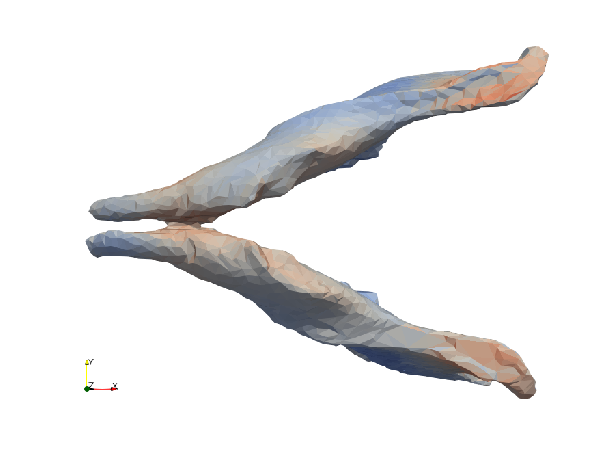

In [17]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
pngfilename = os.path.join(shooting_directory, 'volumechange.png')
plt.figure(figsize=(10,10))
plt.imshow(plt.imread(pngfilename))
plt.axis('off')
plt.show()

## About this notebook

written by Nicolas Toussaint

Contact: <nicolas.a.toussaint@kcl.ac.uk>